# Popularity Analysis

In [18]:
from google.cloud import bigquery
import pandas_gbq
%load_ext google.cloud.bigquery

# Set your default project here
pandas_gbq.context.project = 'snappy-boulder-378707'
pandas_gbq.context.dialect = 'standard'

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import math
pd.set_option('display.max_columns', 500)

## Preprocessing and feature extraction
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
import datetime as dt
from sklearn.preprocessing import FunctionTransformer

## Models
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBRegressor
import timeit

## Model selection and fine tuning
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV

# for model export
import joblib

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../../BigQuery/letsgo-snappy-boulder-378707-4b7d46801fd1.json"

# Construct a BigQuery client object.
client = bigquery.Client()

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [20]:
%%bigquery track_genre
SELECT * FROM snappy-boulder-378707.History.TrackGenre

In [3]:
track_genre

,track_id,Alternative,Blues,Cantopop,Classical,Dance Electronic,Folk & Acoustic,Hip-Hop,Indie,Instrumental,Jazz,K-Pop,Latin,Malay Pop,Mandopop,Metal,Musik Indonesia,Pop,R&B,Rock
0,001CyR8xqmmpVZFiTZJ5BC,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,001eyxfoYptAWzvF4ewLrR,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,002LxxV7VTy5JkvkmmGanl,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,002YdWxaenIUL4PHiv5EB5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,002nFT2kRsfvS0d17AwWsB,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74920,7zo6QXVQfHlycm8dsxkRGv,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
74921,7zswEelYoepv2FYsDaGhUD,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
74922,7zuKKxwcxaeGPrhKoNWdMP,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
74923,7zyfphPnDBks6j6uIjttMR,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


# Import data

## Audio features

In [21]:
%%bigquery audio_feature
SELECT * FROM snappy-boulder-378707.History.AudioFeatures

In [4]:
audio_feature.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'id', 'duration_ms', 'time_signature'],
      dtype='object')

In [6]:
audio_feature

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature
0,0.556,0.7290,0,-5.907,0,0.0432,0.0331,0.015200,0.0907,0.1520,90.003,2LRqm962By8aNwJX0WxFNG,245204,4
1,0.825,0.1240,0,-11.175,0,0.0706,0.8000,0.000003,0.2430,0.2860,104.724,7rXQXbK4pQo8DSKlZ9ZSjC,230333,3
2,0.315,0.1020,0,-17.621,0,0.0340,0.9850,0.051200,0.1090,0.1850,169.690,0Oqxt6JixieLHbwMfnJGWO,206723,3
3,0.440,0.4970,1,-6.440,0,0.0402,0.0917,0.000000,0.2150,0.2090,73.541,6bBNc3V3PduYNL22lbed5R,156892,4
4,0.400,0.4710,1,-12.394,0,0.1610,0.8880,0.048000,0.1150,0.0385,84.481,5ZSqX1dDJ823Dndw94nogY,67804,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75026,0.881,0.0902,10,-13.818,1,0.1410,0.5470,0.897000,0.1360,0.3840,82.010,2hBSZIMfpkSayib4FO684h,117073,4
75027,0.881,0.6960,11,-3.838,0,0.0797,0.1370,0.000041,0.0927,0.7810,97.002,3mQ6SLdxxaL52Yte7KF2Ks,200667,4
75028,0.881,0.5230,11,-4.870,0,0.3380,0.1420,0.000000,0.0771,0.7500,96.506,6xrjmQMIIYgLgjCOeq2dee,211133,4
75029,0.881,0.3610,11,-14.728,0,0.2370,0.0502,0.004580,0.2460,0.7990,96.430,4HfxDJ0uLHTLe0fZrx0MbQ,216693,4


## Tracks info

In [23]:
%%bigquery track_info
SELECT * FROM snappy-boulder-378707.History.Tracks
WHERE popularity <> 0 and available_markets <> 0

In [8]:
track_info.head()

,id,name,album_id,artist_id,popularity,explicit,available_markets,extract_date
0,4feAlo2wgcAtOx6ED9jw2q,Face in the Crowd,2oRM1rJALdQfceK3i7SxG3,5pDjmC5mRl7vDJhsjVwNfk,36,0,134,2023-04-07
1,6f6jhTzxwvAYhzZrABTO8T,Weekends,2oRM1rJALdQfceK3i7SxG3,5pDjmC5mRl7vDJhsjVwNfk,34,1,134,2023-04-07
2,4xo2cd0kmp3GO1jZzAst1D,Can I Jump?,2oRM1rJALdQfceK3i7SxG3,5pDjmC5mRl7vDJhsjVwNfk,56,0,134,2023-04-07
3,6gVIrj4H3rmXYZnFXxtEl3,midnight rendezvous,4XAi7fxJkMgdqS73Wjte5J,4wkxDp8esk6g2W9Fw7IQGY,45,0,176,2023-04-07
4,2Wd0jIZnZI0gkze7ux0ZXs,Cut (Bendik HK Remix),3RtfM1haEzNzgmANkQPcLJ,0Q6X1jqwOVQuclYp2P1bub,4,0,179,2023-04-07


## Album info

In [24]:
%%bigquery release_date
SELECT id,release_date FROM snappy-boulder-378707.History.Albums

In [10]:
release_date

,id,release_date
0,7rG4h8pLLcr6kW30cbSWD8,2023-04-07
1,2oRM1rJALdQfceK3i7SxG3,2023-03-24
2,4XAi7fxJkMgdqS73Wjte5J,2023-03-24
3,3RtfM1haEzNzgmANkQPcLJ,2023-03-31
4,22MkBC5l2Zi9atm66fE0Jq,2023-03-22
...,...,...
58130,4nvvfshb8jFXz5dmRL2zEe,2023-03-17
58131,0Z0dI0YMz5SgfXbElTztrs,2023-03-17
58132,65SUE4gUrSXcU2n02NldKN,2023-03-17
58133,2O1vg5NUciYqMXukzwvpIY,2023-03-17


## Artist_info

In [25]:
%%bigquery artist_info
SELECT distinct id, followers, popularity FROM `snappy-boulder-378707.History.Artists`

In [12]:
artist_info

,id,followers,popularity
0,7oy3avikyzVHespBjOfjGQ,1,0
1,5Knvxyf7V57HhloqIWAGas,2,0
2,6bZ2pW1vt2NJ1XfP3Jwb29,48,0
3,5zuVGovDZ2VKZVuOiM7hCq,5,0
4,2eNMeOUJ4rZQ5uO6ie9hy0,48,0
...,...,...,...
28515,6VuMaDnrHyPL1p4EHjYLi7,19871695,83
28516,2o5jDhtHVPhrJdv3cEQ99Z,6818785,86
28517,7CajNmpbOovFoOoasH2HaY,23293100,87
28518,4MCBfE4596Uoi2O4DtmEMz,28507873,90


## Merge data

In [26]:
df = pd.merge(audio_feature, track_info, on="id", how="inner")
del df['extract_date']
df.drop_duplicates(inplace=True)

In [27]:
df = pd.merge(release_date, df, left_on="id", right_on="album_id",how="inner")
df.head()
df.drop_duplicates(inplace=True)

In [28]:
df= df.assign(artist_id=df.artist_id.str.split(";")).explode('artist_id')
df = pd.merge(df,artist_info, left_on="artist_id", right_on="id",how="inner")
df.head()
df.drop_duplicates(inplace=True)

In [29]:
df = df.groupby(['id_y','release_date', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'name',
       'popularity_x', 'explicit', 'available_markets'], as_index=False).aggregate({'followers':'mean','popularity_y':'mean'})

In [30]:
del df['id_y']

In [31]:
df.columns

Index(['release_date', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'name',
       'popularity_x', 'explicit', 'available_markets', 'followers',
       'popularity_y'],
      dtype='object')

In [32]:
df.columns = ['release_date', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'name', 'popularity_track', 'explicit',
       'available_markets','followers', 'popularity_artist']

In [33]:
df.drop_duplicates(inplace=True)

In [16]:
df

,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,name,popularity_track,explicit,available_markets,followers,popularity_artist
0,2019-07-13,0.238,0.0132,2,-32.252,0,0.0375,0.9940,0.907000,0.0947,0.041,67.773,224250,4,Desvelarse,35,0,184,325.0,50.0
1,2019-05-08,0.675,0.8290,6,-2.962,0,0.0455,0.1170,0.000844,0.2650,0.694,108.914,212138,4,Venus 샛별,33,0,183,16378.0,27.0
2,2020-10-30,0.431,0.0486,6,-23.585,1,0.0334,0.9940,0.906000,0.1070,0.345,156.648,160091,3,Your Love,36,0,185,1872.0,51.0
3,2017-05-05,0.826,0.6790,1,-6.802,1,0.1290,0.3070,0.000025,0.1510,0.841,90.048,160107,4,She Knows How To Rock Me,30,0,184,271037.0,54.5
4,1976-01-01,0.326,0.1810,0,-17.757,1,0.0473,0.9820,0.032700,0.1980,0.144,135.032,602267,3,"Die Meistersinger von Nürnberg, WWV 96 / Act I...",22,0,184,159467.8,48.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73248,2018-11-02,0.551,0.8810,7,-6.099,0,0.0542,0.1860,0.079100,0.1520,0.387,88.036,153000,4,You Get Me So High,80,0,184,12007614.0,85.0
73249,2010-01-01,0.542,0.6560,2,-4.471,0,0.0288,0.0236,0.000000,0.3030,0.262,117.263,369040,4,Kau Dipaksa Aku Terpaksa,43,0,29,503.0,30.0
73250,2023-01-27,0.651,0.7200,9,-6.529,1,0.1610,0.3310,0.413000,0.5280,0.705,90.024,269245,4,running out of time,67,0,183,8870042.0,80.0
73251,2014-12-19,0.423,0.3600,3,-9.458,1,0.0372,0.7280,0.000000,0.1050,0.291,130.576,260573,4,以後別做朋友,60,0,184,1224310.0,67.0


# Data Transformation & Preprocessing

In [34]:
numeric_columns = ['danceability', 'energy', 'loudness', 
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 
       'popularity_track',  'available_markets','followers','popularity_artist']
catego_columns = ['mode','explicit','key', 'time_signature']

In [35]:
imputer_numeric = SimpleImputer(strategy='mean', missing_values=np.nan)
df[numeric_columns] = imputer_numeric.fit_transform(df[numeric_columns])
imputer_catego = SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=0)
df[['mode','explicit','key']] = imputer_catego.fit_transform(df[['mode','explicit','key']])
imputer_catego = SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=4)
df[['time_signature']] = imputer_catego.fit_transform(df[['time_signature']])

In [24]:
df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popularity_track,explicit,available_markets,followers,popularity_artist
count,62837.000000,62837.000000,62837.000000,62837.000000,62837.000000,62837.000000,62837.000000,62837.000000,62837.000000,62837.000000,62837.000000,6.283700e+04,62837.000000,62837.000000,62837.000000,62837.000000,6.283700e+04,62837.000000
mean,0.558198,0.524412,5.238570,-10.193798,0.646434,0.072923,0.434445,0.234545,0.170148,0.429467,118.262838,2.292971e+05,3.886023,40.680825,0.085984,175.805035,2.182322e+06,51.094986
std,0.181739,0.279645,3.543646,6.833567,0.478080,0.077004,0.363059,0.367875,0.135772,0.253652,30.631754,9.569073e+04,0.435211,16.632551,0.280343,33.520675,7.160764e+06,18.981878
min,0.000000,0.000097,0.000000,-47.070000,0.000000,0.000000,0.000000,0.000000,0.007240,0.000000,0.000000,1.594900e+04,0.000000,1.000000,0.000000,1.000000,0.000000e+00,0.000000
25%,0.440000,0.305000,2.000000,-12.523000,0.000000,0.034700,0.065700,0.000000,0.096700,0.217000,94.005000,1.790770e+05,4.000000,29.000000,0.000000,183.000000,1.015400e+04,39.000000
50%,0.574000,0.545000,5.000000,-8.042000,1.000000,0.044400,0.372000,0.000303,0.116000,0.400000,118.144000,2.156670e+05,4.000000,40.000000,0.000000,184.000000,1.478730e+05,52.000000
75%,0.694000,0.759000,8.000000,-5.544000,1.000000,0.071900,0.802000,0.531000,0.191000,0.628000,137.966000,2.589200e+05,4.000000,52.000000,0.000000,185.000000,1.091512e+06,64.333333
max,0.984000,1.000000,11.000000,0.878000,1.000000,0.960000,0.996000,0.997000,1.000000,0.984000,237.488000,4.170227e+06,5.000000,100.000000,1.000000,185.000000,1.107113e+08,100.000000


## EDA

### Distribution of variables

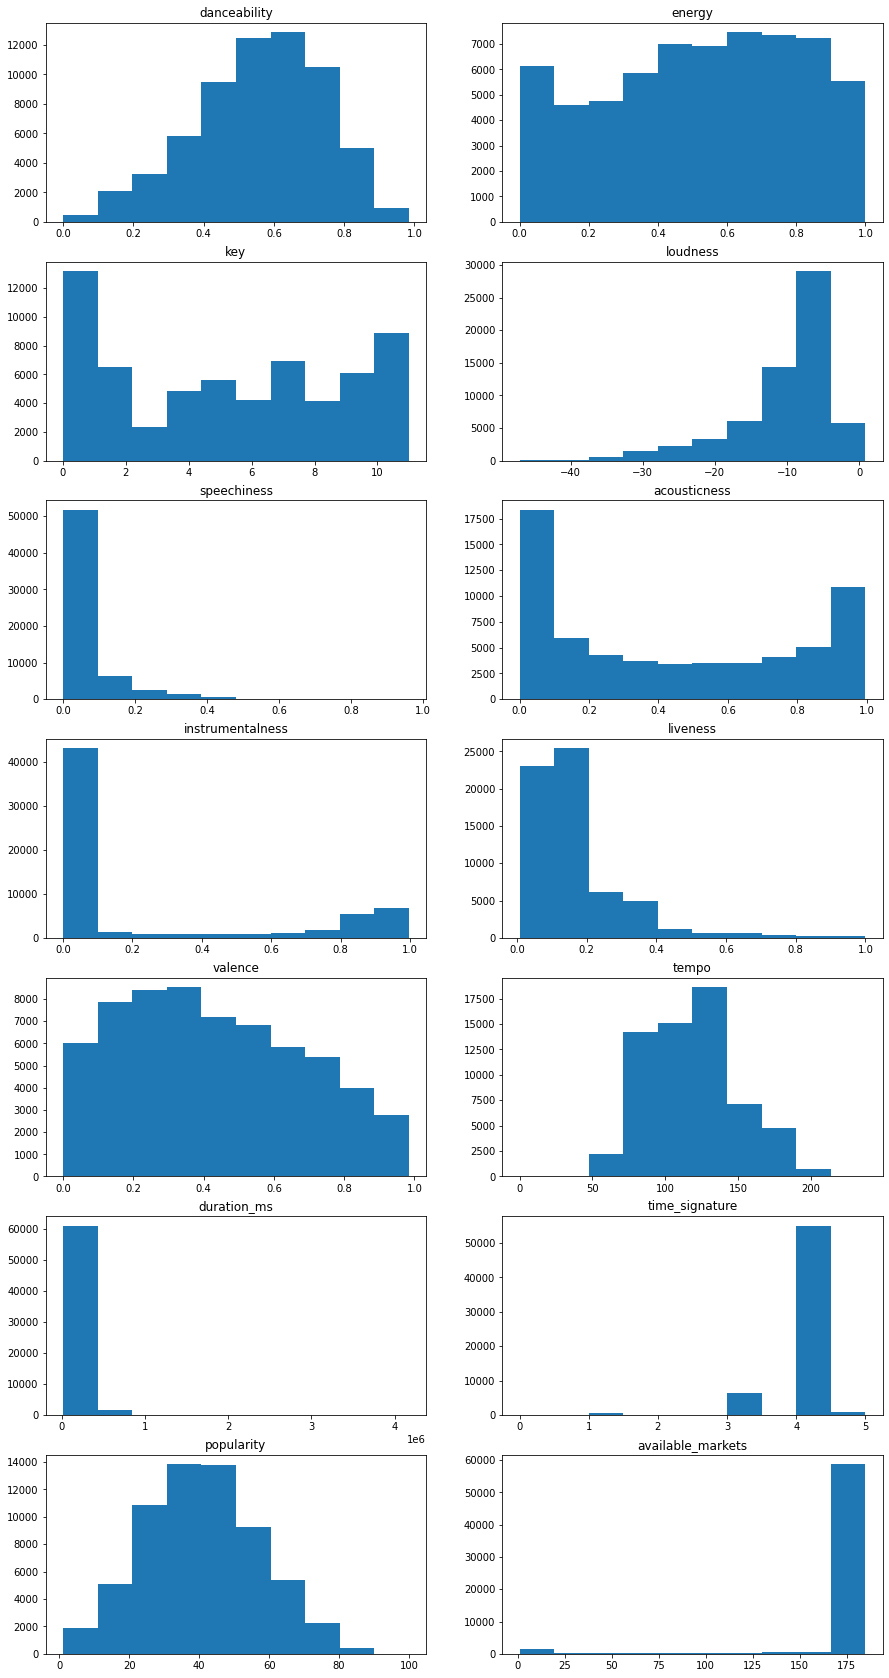

In [25]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10), (ax11, ax12), (ax13, ax14)) = plt.subplots(7, 2,figsize=(15,30))
ax1.hist(df[['danceability']])
ax2.hist(df[['energy']])
ax3.hist(df[['key']])
ax4.hist(df[['loudness']])
ax5.hist(df[['speechiness']])
ax6.hist(df[['acousticness']])
ax7.hist(df[['instrumentalness']])
ax8.hist(df[['liveness']])
ax9.hist(df[['valence']])
ax10.hist(df[['tempo']])
ax11.hist(df[['duration_ms']])
ax12.hist(df[['time_signature']])
ax13.hist(df[['popularity_track']])
ax14.hist(df[['available_markets']])

ax1.title.set_text('danceability')
ax2.title.set_text('energy')
ax3.title.set_text('key')
ax4.title.set_text('loudness')
ax5.title.set_text('speechiness')
ax6.title.set_text('acousticness')
ax7.title.set_text('instrumentalness')
ax8.title.set_text('liveness')
ax9.title.set_text('valence')
ax10.title.set_text('tempo')
ax11.title.set_text('duration_ms')
ax12.title.set_text('time_signature')
ax13.title.set_text('popularity')
ax14.title.set_text('available_markets')

Text(0, 0.5, 'frequency')

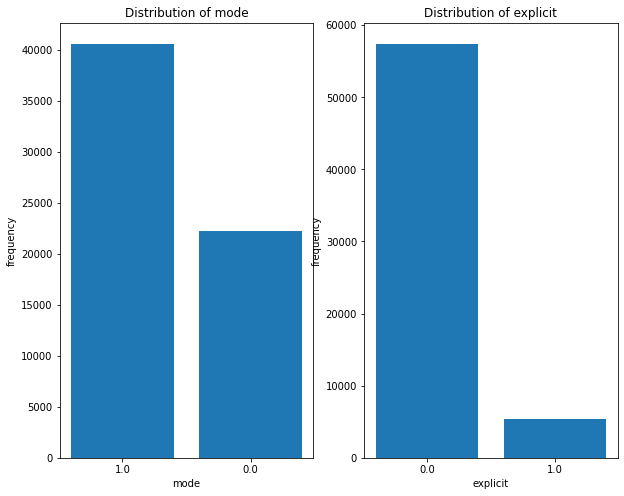

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,8))
ax[0].bar(    
    x=list(map(str,df[catego_columns[0]].value_counts().keys().tolist())),
    height=df[catego_columns[0]].value_counts().values
    )
ax[0].set_title("Distribution of mode")
ax[0].set_xlabel("mode")
ax[0].set_ylabel("frequency")
ax[1].bar(    
    x=list(map(str,df[catego_columns[1]].value_counts().keys().tolist())),
    height=df[catego_columns[1]].value_counts().values
    )
ax[1].set_title("Distribution of explicit")
ax[1].set_xlabel("explicit")
ax[1].set_ylabel("frequency")

Text(0.5, 1.0, 'Popularity Based on Time Signature')

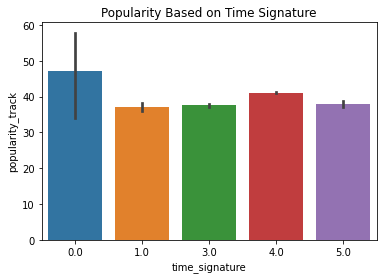

In [27]:
sns.barplot(x = 'time_signature', y = 'popularity_track', data = df)
plt.title('Popularity Based on Time Signature')

Text(0.5, 1.0, 'Popularity Based on Key')

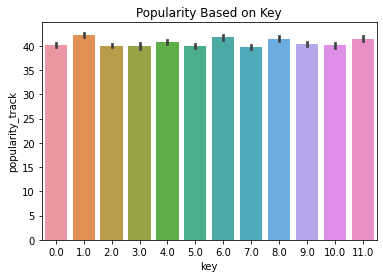

In [28]:
sns.barplot(x = 'key', y = 'popularity_track', data = df)
plt.title('Popularity Based on Key')

Text(0.5, 1.0, 'Popularity Based on Mode')

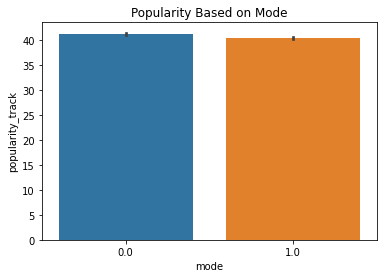

In [29]:
sns.barplot(x = 'mode', y = 'popularity_track', data = df)
plt.title('Popularity Based on Mode')

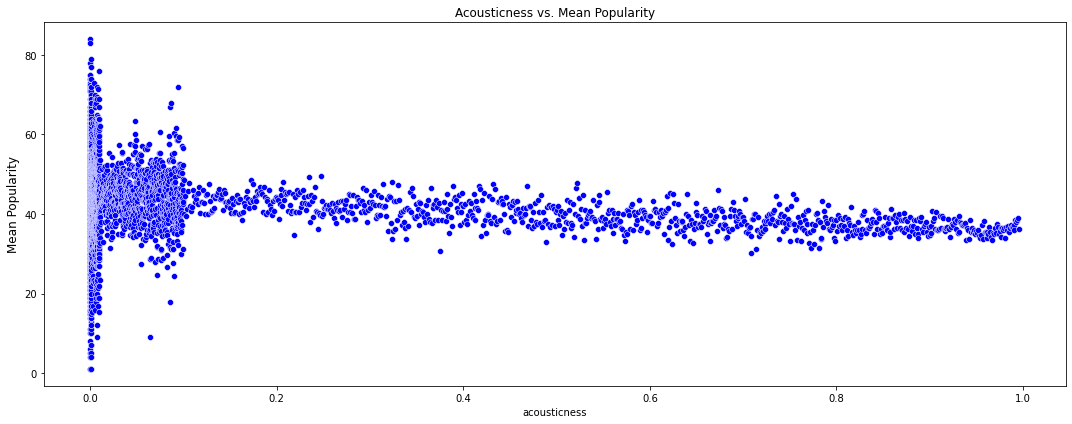

In [30]:
fig, ax = plt.subplots(figsize=(15, 6))
ax1_data =  df.groupby('acousticness')['popularity_track'].mean().to_frame().reset_index()
ax = sns.scatterplot(x=ax1_data['acousticness'], y=ax1_data['popularity_track'], color='blue', ax=ax)
ax.set_title('Acousticness vs. Mean Popularity')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

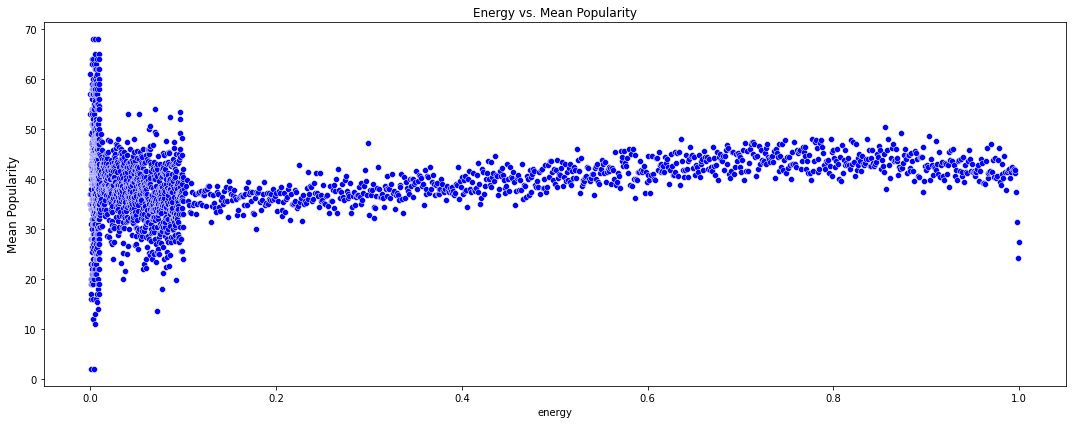

In [31]:
fig, ax = plt.subplots(figsize=(15, 6))
ax1_data =  df.groupby('energy')['popularity_track'].mean().to_frame().reset_index()
ax = sns.scatterplot(x=ax1_data['energy'], y=ax1_data['popularity_track'], color='blue', ax=ax)
ax.set_title('Energy vs. Mean Popularity')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

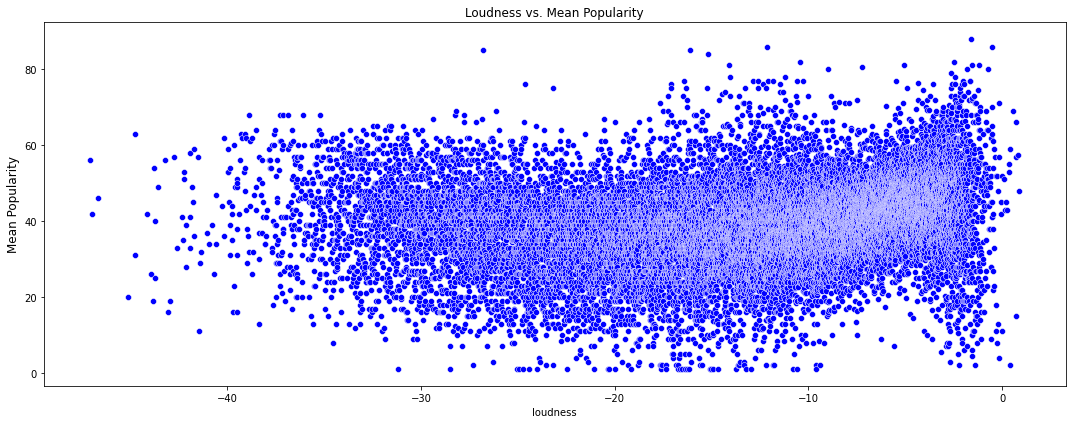

In [32]:
fig, ax = plt.subplots(figsize=(15, 6))
ax1_data =  df.groupby('loudness')['popularity_track'].mean().to_frame().reset_index()
ax = sns.scatterplot(x=ax1_data['loudness'], y=ax1_data['popularity_track'], color='blue', ax=ax)
ax.set_title('Loudness vs. Mean Popularity')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

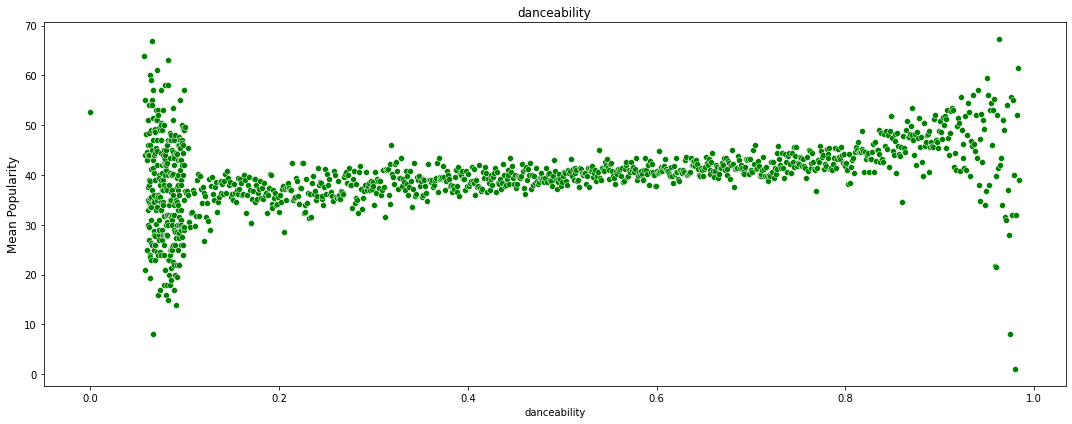

In [33]:
fig, ax = plt.subplots(1, figsize=(15, 6), sharey=True, sharex = True)
ax_data =  df.groupby('danceability')['popularity_track'].mean().to_frame().reset_index()
ax = sns.scatterplot(x='danceability', y='popularity_track', data=ax_data, color='green', ax=ax)
ax.set_title('danceability')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

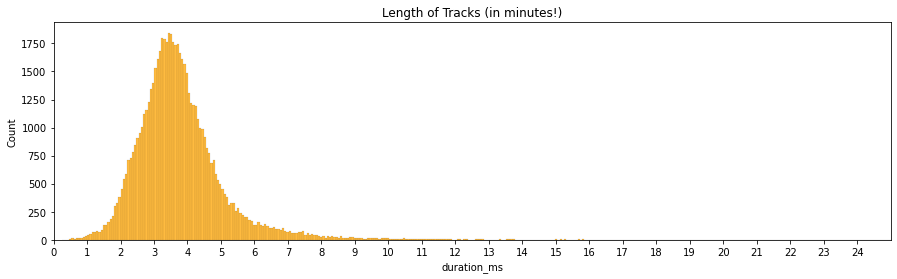

In [34]:
fig, ax = plt.subplots(figsize = (15, 4))
ax = sns.histplot(df['duration_ms']/60000, color='orange')
ax.set_title('Length of Tracks (in minutes!)')
ax.set_xticks(range(0,25,1))
ax.set_xlim(0,25)
plt.show()

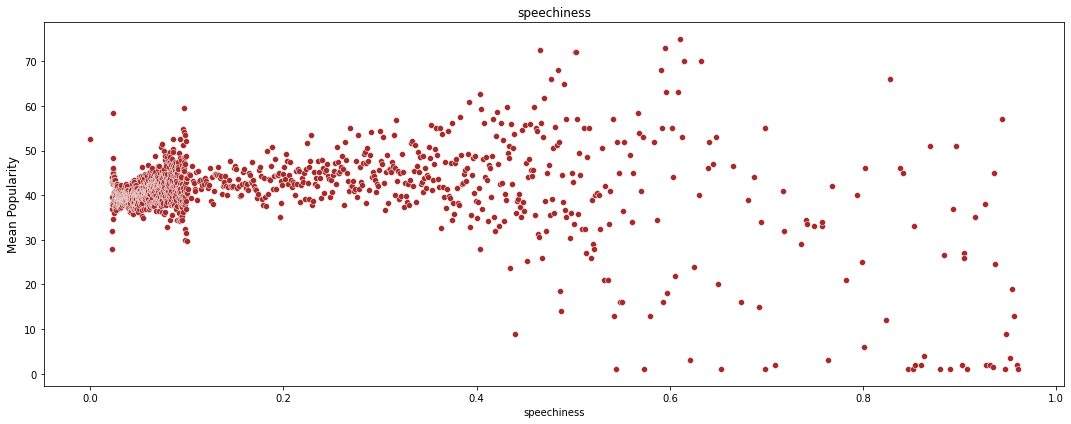

In [35]:
fig, ax = plt.subplots(1, figsize=(15, 6), sharey=True, sharex = True)
ax_data =  df.groupby('speechiness')['popularity_track'].mean().to_frame().reset_index()
ax = sns.scatterplot(x='speechiness', y='popularity_track', data=ax_data, color='brown', ax=ax)
# ax.axvline(x=0.57, ymin=0, ymax=1, color='red', linestyle='dashed')
ax.set_title('speechiness')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

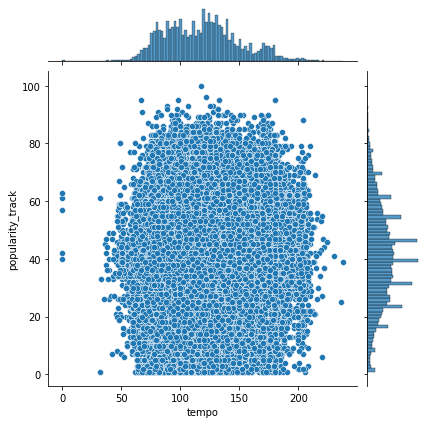

In [37]:
sns.jointplot(x='tempo', y='popularity_track', data=df)
plt.show()

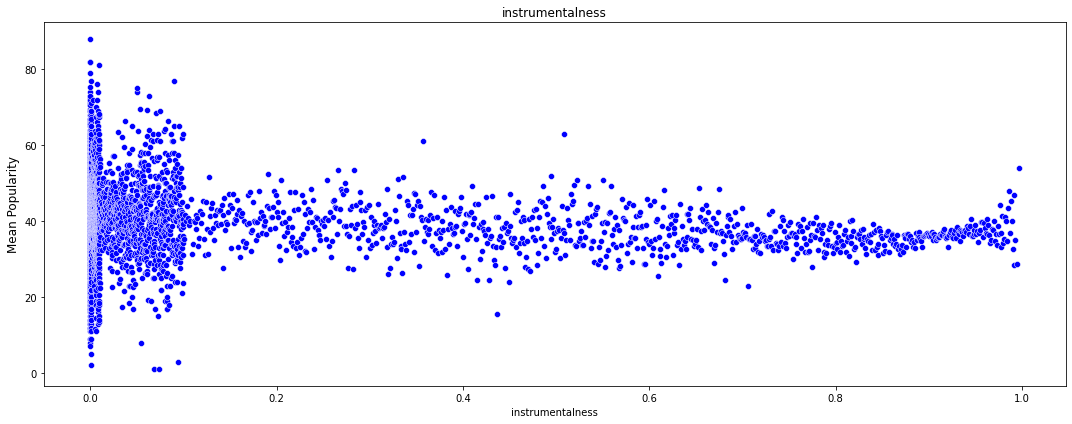

In [38]:
fig, ax = plt.subplots(1, figsize=(15, 6), sharey=True, sharex = True)
ax_data =  df.groupby('instrumentalness')['popularity_track'].mean().to_frame().reset_index()
ax = sns.scatterplot(x='instrumentalness', y='popularity_track', data=ax_data, color='blue', ax=ax)
ax.set_title('instrumentalness')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

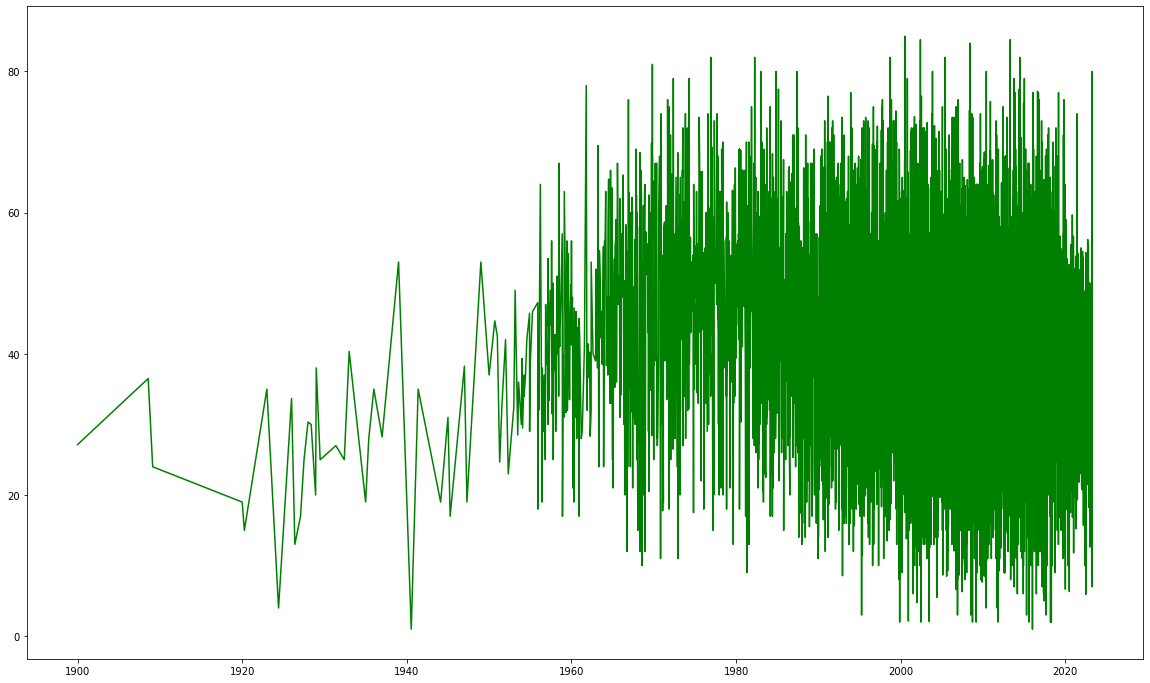

In [40]:
date_with_mean_pop = df.groupby('release_date')['popularity_track'].mean().to_frame().reset_index()
plt.figure(figsize=(20,12))
plt.plot_date(date_with_mean_pop[['release_date']],date_with_mean_pop[['popularity_track']], 'g')

## Correlation between features

<Axes: >

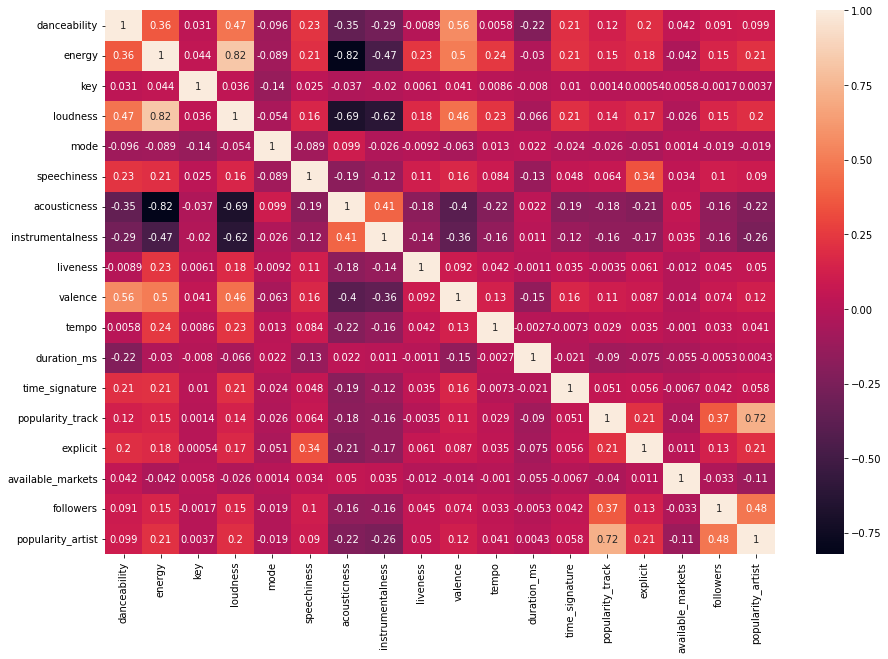

In [67]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),annot=True)

# Model Buiding

In [120]:
df.head()

,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,name,popularity_track,explicit,available_markets,followers,popularity_artist
0,2019-07-13,0.238,0.0132,2,-32.252,0,0.0375,0.994,0.907000,0.0947,0.0410,67.773,224250,4,Desvelarse,35,0,184,325.0,50.0
1,2019-05-08,0.675,0.8290,6,-2.962,0,0.0455,0.117,0.000844,0.2650,0.6940,108.914,212138,4,Venus 샛별,33,0,183,16378.0,27.0
2,2017-05-05,0.826,0.6790,1,-6.802,1,0.1290,0.307,0.000025,0.1510,0.8410,90.048,160107,4,She Knows How To Rock Me,30,0,184,271037.0,54.5
3,1976-01-01,0.326,0.1810,0,-17.757,1,0.0473,0.982,0.032700,0.1980,0.1440,135.032,602267,3,"Die Meistersinger von Nürnberg, WWV 96 / Act I...",22,0,184,159467.8,48.6
4,2022-03-18,0.385,0.1080,0,-21.476,1,0.0537,0.969,0.107000,0.1080,0.0799,82.763,212827,3,This Foolish Heart Could Love You,42,0,183,322204.5,51.5


First, we need to split the data.

If we consider the usecase of Spotify, the company certainly wants to predict the popularity of future songs. Thus, we should split the dataset between songs issued before a certain year and songs issued after it.

We will make a train set of all the songs previous to 2022-8-18, and a test set composed of the songs issued on and after 2022-8-18 (20% of the total dataset).

In [50]:
X = df.sort_values(by='release_date').drop(columns=['popularity_track','name']).copy()
y = df.sort_values(by='release_date')['popularity_track'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [20]:
X_train.tail(5)

,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,explicit,available_markets,followers,popularity_artist
42541,2022-09-29,0.667,0.326,4.0,-9.807,0.0,0.0280,0.869000,0.8520,0.113,0.143,69.022,113587.0,4.0,0.0,185.0,6.0,20.000000
58736,2022-09-29,0.745,0.506,7.0,-10.675,1.0,0.0395,0.226000,0.0000,0.273,0.564,119.955,210000.0,4.0,0.0,184.0,259.0,18.000000
70363,2022-09-29,0.600,0.960,7.0,-2.396,0.0,0.0597,0.000707,0.0475,0.381,0.153,128.068,178125.0,4.0,1.0,183.0,13571014.0,86.333333
1204,2022-09-29,0.785,0.769,5.0,-1.919,0.0,0.0488,0.079900,0.0000,0.111,0.947,124.983,195080.0,4.0,0.0,184.0,739313.0,61.500000
17499,2022-09-29,0.544,0.628,0.0,-5.320,1.0,0.0363,0.432000,0.0000,0.171,0.213,100.115,199295.0,4.0,0.0,185.0,158859.0,52.000000


In [51]:
X_train['release_date']=X_train['release_date'].map(dt.datetime.toordinal)
X_test['release_date']=X_test['release_date'].map(dt.datetime.toordinal)

In [52]:
X_train['release_date']=X_train['release_date'].map(lambda x: dt.datetime.now().toordinal() - x)
X_test['release_date']=X_test['release_date'].map(lambda x: dt.datetime.now().toordinal() - x)

In [53]:
X_train.describe()

,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,explicit,available_markets,followers,popularity_artist
count,58682.000000,58682.000000,58682.000000,58682.000000,58682.000000,58682.000000,58682.000000,58682.00000,58682.000000,58682.000000,58682.000000,58682.000000,5.868200e+04,58682.000000,58682.000000,58682.000000,5.868200e+04,58682.000000
mean,3840.987748,0.545660,0.501795,5.213745,-10.996768,0.655584,0.069032,0.46243,0.260690,0.167011,0.419684,117.450148,2.315763e+05,3.874953,0.070004,175.784448,2.139632e+06,50.736543
std,5065.449760,0.187133,0.290797,3.540941,7.636100,0.475181,0.070646,0.37141,0.382859,0.133349,0.257411,30.727403,9.657006e+04,0.454812,0.255157,33.752885,7.149103e+06,18.340783
min,201.000000,0.000000,0.000270,0.000000,-47.903000,0.000000,0.000000,0.00000,0.000000,0.007240,0.000000,0.000000,1.900000e+04,0.000000,0.000000,1.000000,0.000000e+00,0.000000
25%,585.000000,0.424000,0.259000,2.000000,-13.743000,0.000000,0.034600,0.07710,0.000000,0.096400,0.202000,93.175500,1.807200e+05,4.000000,0.000000,184.000000,8.532000e+03,38.500000
50%,1516.000000,0.562000,0.520000,5.000000,-8.436500,1.000000,0.043600,0.42400,0.000609,0.115000,0.387000,117.396500,2.177600e+05,4.000000,0.000000,184.000000,1.399500e+05,51.000000
75%,5295.000000,0.687000,0.749000,8.000000,-5.676000,1.000000,0.066900,0.85100,0.708000,0.184000,0.620000,136.995750,2.615900e+05,4.000000,0.000000,185.000000,1.029225e+06,64.000000
max,45032.000000,0.984000,1.000000,11.000000,1.519000,1.000000,0.959000,0.99600,0.997000,1.000000,0.987000,224.536000,4.170227e+06,5.000000,1.000000,185.000000,1.107113e+08,100.000000


In [125]:
y_train.tail(5)

35951    41
58019    38
2874     34
45614    64
34123    29
Name: popularity_track, dtype: Int64

In [54]:
ct = ColumnTransformer([('minmax', MinMaxScaler(), ['release_date','loudness', 'tempo', 'duration_ms','available_markets','followers','popularity_artist']),
                        ('categorical', OneHotEncoder(handle_unknown = 'ignore'), ['key','mode','time_signature','explicit']),
                       ],
                       remainder='passthrough')

ct.fit(X_train)
joblib.dump(ct, 'Popularity Prediction Data Preprocess.joblib')

X_train_preprocessed = pd.DataFrame(ct.transform(X_train))
X_test_preprocessed = pd.DataFrame(ct.transform(X_test))

In [55]:
X_test_preprocessed

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
0,0.000000,0.853729,0.378688,0.034630,1.000000,2.705234e-05,0.365000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.696,0.54800,0.0577,0.15100,0.011700,0.2820,0.631
1,0.000000,0.693315,0.544011,0.054406,0.978261,7.609822e-03,0.520000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.380,0.71300,0.0533,0.24500,0.936000,0.9860,0.700
2,0.000000,0.205091,0.321499,0.036220,1.000000,2.203930e-06,0.430000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.162,0.00174,0.0443,0.98600,0.890000,0.1120,0.112
3,0.000000,0.535227,0.369651,0.029032,1.000000,9.935749e-07,0.240000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.688,0.10300,0.0433,0.94300,0.942000,0.1070,0.125
4,-0.000022,0.843693,0.414481,0.105510,1.000000,2.848489e-04,0.380000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.518,0.69600,0.0595,0.15100,0.000250,0.7710,0.690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14666,-0.004394,0.828518,0.792946,0.036616,0.994565,1.185801e-02,0.680000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.763,0.51400,0.1420,0.19500,0.000000,0.1030,0.181
14667,-0.004394,0.806948,0.605818,0.028990,0.994565,1.294158e-03,0.580000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.633,0.43400,0.0752,0.50700,0.000122,0.1950,0.209
14668,-0.004394,0.796245,0.402163,0.035096,0.994565,1.633082e-03,0.583333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.728,0.63600,0.0462,0.00841,0.712000,0.2910,0.604
14669,-0.004394,0.811541,0.560088,0.039472,0.994565,1.294158e-03,0.580000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.679,0.42000,0.0912,0.71100,0.006020,0.2960,0.534


In [56]:
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [57]:
y_train = y_train.astype(float)
y_test = y_test.astype(float)

In [58]:
# verifictaion
nl = '\n'
print(f'X_train_preprocessed shape is: {X_train_preprocessed.shape} {nl}y_train shape is: {y_train.shape} {nl}X_test_preprocessed shape is: {X_test_preprocessed.shape} {nl}y_test shape is: {y_test.shape}')

X_train_preprocessed shape is: (58682, 35) 
y_train shape is: (58682,) 
X_test_preprocessed shape is: (14671, 35) 
y_test shape is: (14671,)


### Linear Regression (selected features only (corr > 0.1))

In [85]:
X_train_preprocessed.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
0,0.0,0.738884,0.605524,0.036285,0.978261,0.000175,0.4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.570,0.324,0.0499,0.941,0.00166,0.1900,0.882
1,0.0,0.726454,0.415510,0.042339,0.978261,0.000175,0.4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.535,0.249,0.0332,0.952,0.07910,0.0905,0.823
2,0.0,0.732126,0.599645,0.048146,0.978261,0.000175,0.4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.577,0.303,0.0416,0.951,0.00000,0.2150,0.825


In [86]:
X_train_preprocessed.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
count,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.00000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000,50269.000000
mean,0.909947,0.767353,0.526534,0.052532,0.942403,0.022156,0.524616,0.120571,0.089180,0.105791,0.036623,0.077801,0.090254,0.065070,0.111520,0.064473,0.097635,0.066701,0.074380,0.343751,0.656249,0.000119,0.00933,0.102628,0.873282,0.014641,0.926197,0.073803,0.550204,0.524053,0.069589,0.437086,0.217543,0.170183,0.433166
std,0.117470,0.145939,0.135278,0.023731,0.195884,0.068879,0.186191,0.325632,0.285007,0.307573,0.187836,0.267862,0.286549,0.246652,0.314778,0.245596,0.296823,0.249506,0.262391,0.474964,0.474964,0.010925,0.09614,0.303475,0.332660,0.120113,0.261453,0.261453,0.183928,0.282637,0.071718,0.363935,0.358102,0.136720,0.256762
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000270,0.000000,0.000000,0.000000,0.007240,0.000000
25%,0.869522,0.718570,0.421393,0.040421,0.989130,0.000195,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,1.000000,0.000000,0.430000,0.301000,0.034300,0.067200,0.000000,0.095800,0.218000
50%,0.962044,0.814153,0.525644,0.048896,0.994565,0.001877,0.540000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,1.000000,0.000000,1.000000,0.000000,0.565000,0.546000,0.043400,0.376000,0.000201,0.116000,0.404000
75%,0.989395,0.866877,0.611822,0.059372,1.000000,0.012269,0.650000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.00000,0.000000,1.000000,0.000000,1.000000,0.000000,0.688000,0.762000,0.067800,0.806000,0.367000,0.192000,0.636000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,0.983000,1.000000,0.959000,0.996000,0.997000,1.000000,0.984000


In [25]:
LR = LinearRegression()
cols = [col for col in X_train_preprocessed.columns if abs(X_train_preprocessed[col].corr((y_train).astype(float)))>0.1]

# Fit the model and
LR.fit(X_train_preprocessed.drop(columns=cols), y_train)

# Train Predicting with the model
y_train_pred = LR.predict(X_train_preprocessed.drop(columns=cols))
# RMSE Train
LR_rmse = np.sqrt(mse(y_train, y_train_pred))
print(f"RMSE Train = {LR_rmse:.5f}")

RMSE Train = 15.87542


In [26]:
#Predicting with the model
y_test_pred = LR.predict(X_test_preprocessed.drop(columns=cols))#.clip(0, 1)

# RMSE Test
LR_rmse = np.sqrt(mse(y_test, y_test_pred))
print(f"RMSE Val = {LR_rmse:.5f}")

RMSE Val = 15.41965


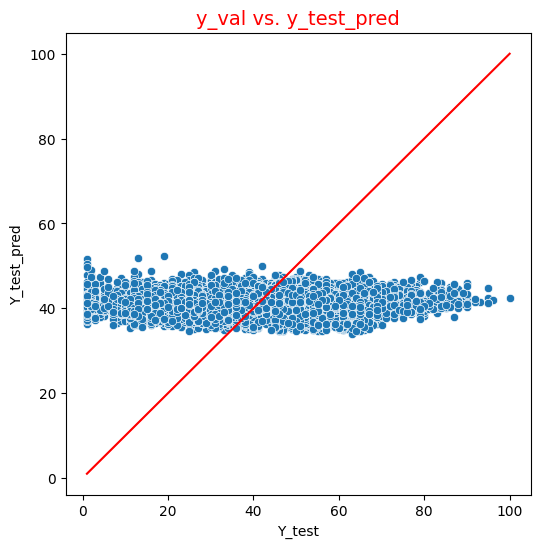

In [27]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_test, y=y_test_pred)
sns.lineplot(x=y_test.astype(float), y=y_test.astype(float), color='red', ax=ax)
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')
ax.set_title('y_val vs. y_test_pred', fontsize=14, color='red')
plt.show()

### Linear Regression (all features)

In [28]:
# Count time
start_time = timeit.default_timer()
LR = LinearRegression()

# Fit the model and
LR.fit(X_train_preprocessed, y_train)
elapsed_1 = timeit.default_timer() - start_time

# Train Predicting with the model
y_train_pred2 = LR.predict(X_train_preprocessed)#.clip(0, 1)

# RMSE Train
LR_rmse2 = np.sqrt(mse(y_train, y_train_pred2))
print(f"RMSE Train = {LR_rmse2:.6f}")

RMSE Train = 11.465714


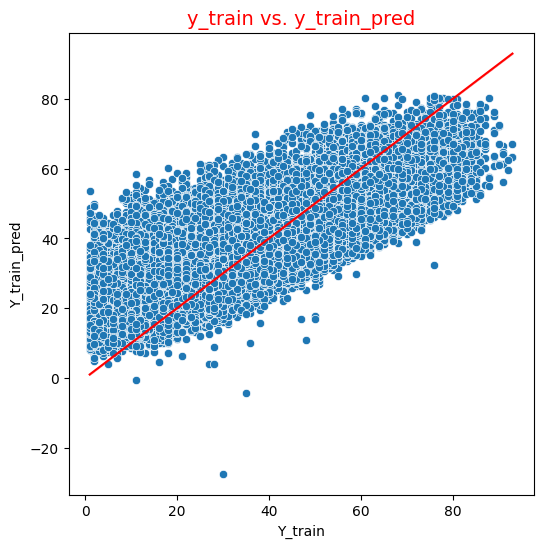

In [29]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_train, y=y_train_pred2)
sns.lineplot(x=y_train, y=y_train, color='red', ax=ax)
ax.set_xlabel('Y_train')
ax.set_ylabel('Y_train_pred')
ax.set_title('y_train vs. y_train_pred', fontsize=14, color='red')
plt.show()

In [30]:
#Predicting with the model
start_time = timeit.default_timer()
lr_pred = LR.predict(X_test_preprocessed)#.clip(0, 1)
elapsed_1_predict = timeit.default_timer() - start_time

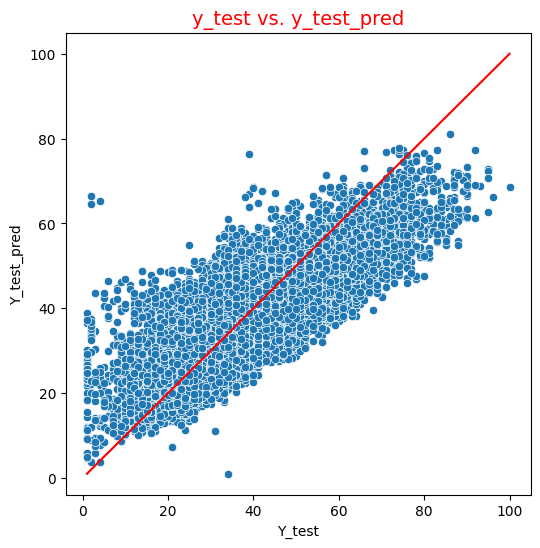

In [31]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_test, y=lr_pred)
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax)
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')
ax.set_title('y_test vs. y_test_pred', fontsize=14, color='red')
plt.show()

In [32]:
model = sm.OLS(list(y_train), X_train_preprocessed).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     1799.
Date:                Mon, 10 Apr 2023   Prob (F-statistic):               0.00
Time:                        11:40:44   Log-Likelihood:            -2.2610e+05
No. Observations:               58602   AIC:                         4.523e+05
Df Residuals:                   58570   BIC:                         4.526e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              4.5690      0.458      9.976      0.000       3.671       5.467
1            -12.6967      0.685    -18.532      0.000     -14.040     -11.354
2              0.5019      0.365      1.373      0.170      -0.214       1.218
3            -65.3427      2.139    -30.542      0.000     -69.536     -61.149
4              3.2550      0.263     12.391      0.000       2.740       3.770
5             10.4158      0.847     12.292      0.000       8.755      12.077
6             59.0164      0.316    186.649      0.000      58.397      59.636
7              1.2125      0.154      7.879      0.000       0.911       1.514
8              1.3147      0.173      7.585      0.000       0.975       1.654
9              1.2979      0.161      8.080      0.000       0.983       1.613
10             1.7478      0.242      7.228      0.000       1.274       2.222
11             1.4883      0.180      8.270      0.000       1.136       1.841
12             0.8498      0.170      4.985      0.000       0.516       1.184
13             1.4671      0.195      7.541      0.000       1.086       1.848
14             0.8859      0.159      5.570      0.000       0.574       1.198
15             1.3846      0.194      7.135      0.000       1.004       1.765
16             1.3681      0.165      8.285      0.000       1.044       1.692
17             0.9848      0.191      5.153      0.000       0.610       1.359
18             1.3930      0.186      7.483      0.000       1.028       1.758
19             7.7062      0.466     16.550      0.000       6.794       8.619
20             7.6883      0.463     16.595      0.000       6.780       8.596
21             8.0313      3.897      2.061      0.039       0.393      15.670
22             2.0817      0.888      2.343      0.019       0.340       3.823
23             1.4259      0.816      1.747      0.081      -0.174       3.026
24             1.7348      0.812      2.138      0.033       0.144       3.326
25             2.1207      0.860      2.466      0.014       0.435       3.806
26             5.5396      0.463     11.968      0.000       4.632       6.447
27             9.8549      0.483     20.415      0.000       8.909      10.801
28             2.0193      0.364      5.548      0.000       1.306       2.733
29            -0.0203      0.414     -0.049      0.961      -0.831       0.791
30            -9.2141      0.747    -12.343      0.000     -10.677      -7.751
31            -1.8856      0.239     -7.902      0.000      -2.353      -1.418
32             1.1404      0.175      6.515      0.000       0.797       1.484
33            -4.3414      0.371    -11.699      0.000      -5.069      -3.614
34             1.5690      0.262      5.987      0.000       1.055       2.083
==============================================================================
Om

In [33]:
r2_lr = r2_score(y_test, y_test_pred)
LR_rmse2 = np.sqrt(mse(y_test, y_test_pred))
print("R-Squared = {:.6f}".format(round(r2_lr, 6)))
print('Run time = ', elapsed_1)
print(f"RMSE Test = {LR_rmse2:.6f}")

R-Squared = -0.009640
Run time =  0.3857126019993302
RMSE Test = 15.419653


### Lasso

In [34]:
# Count time
start_time = timeit.default_timer()
# Lasso
lasso=Lasso(alpha=0.001)
lasso_fit = lasso.fit(X_train_preprocessed,y_train)
elapsed_2 = timeit.default_timer() - start_time

start_time = timeit.default_timer()
lasso_pred = lasso.predict(X_test_preprocessed)#.clip(0, 1)
elapsed_2_predict = timeit.default_timer() - start_time
mean_squared_error(y_test, lasso_pred, squared=False)

9.811128760759082

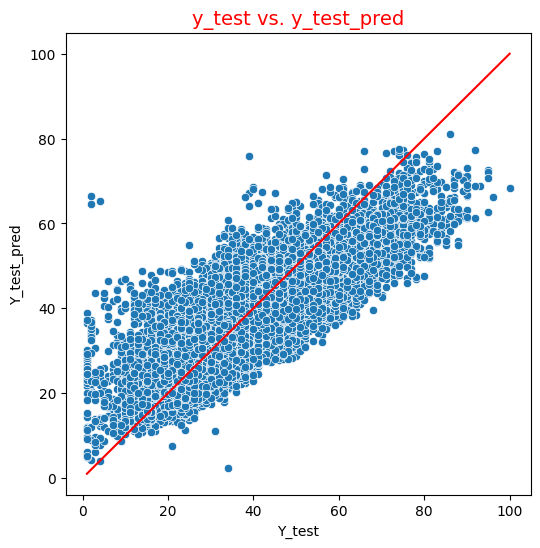

In [35]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_test, y=lasso_pred)
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax)
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')
ax.set_title('y_test vs. y_test_pred', fontsize=14, color='red')
plt.show()

In [36]:
r2_lasso = r2_score(y_test, lasso_pred)
lasso_rmse = np.sqrt(mse(y_test, lasso_pred))
print('Run time = ', elapsed_2)
print(f"RMSE Test = {lasso_rmse:.6f}")

Run time =  27.444869750999715
RMSE Test = 9.811129


### XGBoost Regression

In [132]:
def hyperParameterTuning(x, y):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }

    xgb_model = XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(x,y)

    return gsearch.best_params_

In [133]:
hyperParameterTuning(X_train_preprocessed,y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 10,
 'min_child_weight': 5,
 'n_estimators': 500,
 'objective': 'reg:squarederror',
 'subsample': 0.7}

In [69]:
# Count time
start_time = timeit.default_timer()
# XGBoost regressor
xgb_regressor = XGBRegressor(n_estimators=500, max_depth=10, learning_rate=0.01, colsample_bytree = 0.7,
                             min_child_weight = 5, objective =  'reg:squarederror',subsample = 0.7)
xgb_fit = xgb_regressor.fit(X_train_preprocessed, y_train)
elapsed_3 = timeit.default_timer() - start_time

start_time = timeit.default_timer()
y_pred_xg = xgb_regressor.predict(X_test_preprocessed)#.clip(0, 1)
elapsed_3_predict = timeit.default_timer() - start_time
np.sqrt(mean_squared_error(y_test, y_pred_xg))

9.077555085043473

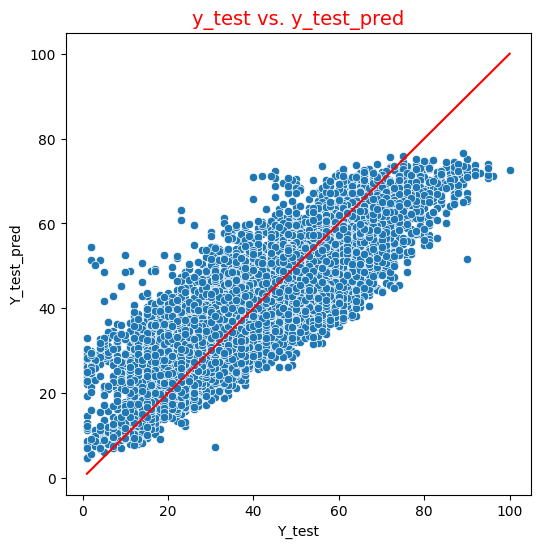

In [70]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_test, y=y_pred_xg)
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax)
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')
ax.set_title('y_test vs. y_test_pred', fontsize=14, color='red')
plt.show()

In [71]:
xgboost_rmse = np.sqrt(mse(y_test, y_pred_xg))
print('Run time = ', elapsed_3)
print(f"RMSE Test = {xgboost_rmse:.6f}")

Run time =  45.37241611201898
RMSE Test = 9.077555


## LightGBM

In [43]:
from lightgbm import LGBMRegressor
def hyperParameterTuning(x, y):
    param_tuning = {
        'learning_rate': [0.01, 0.1,0.001],
        'max_depth': [10,15,20],
        'num_leaves':[2**10,2**15,2**20],
        'n_estimators' : [100, 200, 500]
    }

    lgbm_model = LGBMRegressor()

    gsearch = GridSearchCV(estimator = lgbm_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(x,y)

    return gsearch.best_params_

In [44]:
hyperParameterTuning(X_train_preprocessed,y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[LightGBM] [Fatal] Check failed: (num_leaves) <= (131072) at /Users/runner/work/1/s/python-package/compile/src/io/config_auto.cpp, line 335 .

[LightGBM] [Fatal] Check failed: (num_leaves) <= (131072) at /Users/runner/work/1/s/python-package/compile/src/io/config_auto.cpp, line 335 .

[LightGBM] [Fatal] Check failed: (num_leaves) <= (131072) at /Users/runner/work/1/s/python-package/compile/src/io/config_auto.cpp, line 335 .

[LightGBM] [Fatal] Check failed: (num_leaves) <= (131072) at /Users/runner/work/1/s/python-package/compile/src/io/config_auto.cpp, line 335 .

[LightGBM] [Fatal] Check failed: (num_leaves) <= (131072) at /Users/runner/work/1/s/python-package/compile/src/io/config_auto.cpp, line 335 .

[LightGBM] [Fatal] Check failed: (num_leaves) <= (131072) at /Users/runner/work/1/s/python-package/compile/src/io/config_auto.cpp, line 335 .

[LightGBM] [Fatal] Check failed: (num_leaves) <= (131072) at /Users/runner/work/1/s/python-package/compile/src/io/config_auto.cpp, line 335 .


{'learning_rate': 0.01,
 'max_depth': 10,
 'n_estimators': 500,
 'num_leaves': 1024}

In [63]:
# define the model
lgbm_raw = LGBMRegressor()
# fit the model on the whole dataset
lgbm_raw.fit(X_train_preprocessed, y_train)
y_pred_lgbm_raw=lgbm_raw.predict(X_test_preprocessed)

In [64]:
lgbm_raw_rmse = np.sqrt(mse(y_test, y_pred_lgbm_raw))
print(f"RMSE Test = {lgbm_raw_rmse:.6f}")

RMSE Test = 8.994655


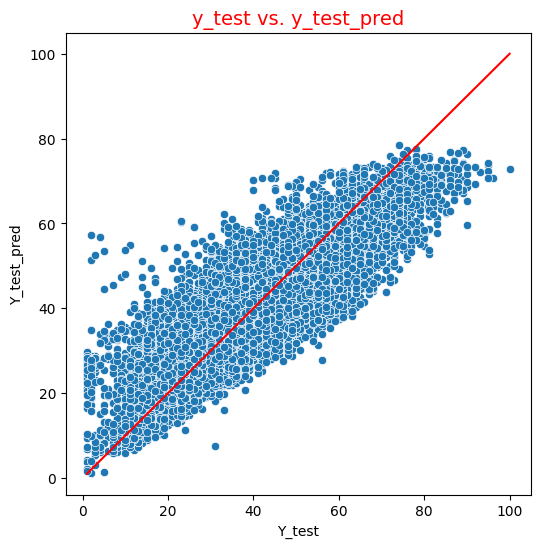

In [65]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_test, y=y_pred_lgbm_raw)
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax)
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')
ax.set_title('y_test vs. y_test_pred', fontsize=14, color='red')
plt.show()

In [66]:
# define the model
lgbm = LGBMRegressor(n_estimators=500,max_depth=10, num_leaves=2**10,learning_rate=0.01)
# fit the model on the whole dataset
lgbm.fit(X_train_preprocessed, y_train)
y_pred_lgbm=lgbm.predict(X_test_preprocessed)

In [67]:
lgbm_rmse = np.sqrt(mse(y_test, y_pred_lgbm))
print(f"RMSE Test = {lgbm_rmse:.6f}")

RMSE Test = 9.032600


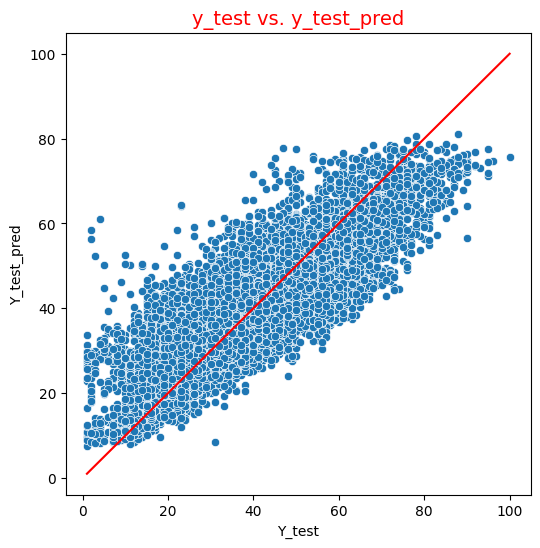

In [68]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_test, y=y_pred_lgbm)
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax)
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')
ax.set_title('y_test vs. y_test_pred', fontsize=14, color='red')
plt.show()

## K-Nearest-Neighbors (KNN) Regression

In [48]:
# Count time
start_time = timeit.default_timer()
# K-Nearest-Neighbors (KNN) regressor
neigh = KNeighborsRegressor(n_neighbors=7)

neigh_fit = neigh.fit(X_train_preprocessed, y_train)
elapsed_4 = timeit.default_timer() - start_time

start_time = timeit.default_timer()
y_pred_kn=neigh.predict(X_test_preprocessed)#.clip(0, 1)
elapsed_4_predict = timeit.default_timer() - start_time

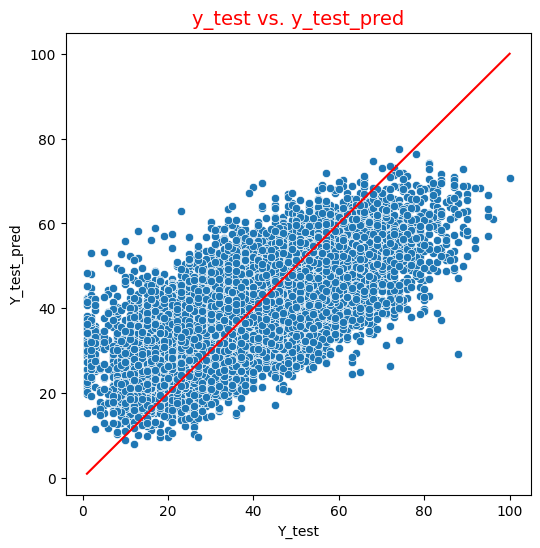

In [49]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_test, y=y_pred_kn)
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax)
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')
ax.set_title('y_test vs. y_test_pred', fontsize=14, color='red')
plt.show()

In [50]:
knn_rmse = np.sqrt(mse(y_test, y_pred_kn))
print(f"RMSE Test = {knn_rmse:.6f}")
print('Run time = ', elapsed_4)

RMSE Test = 11.547321
Run time =  0.03337317900150083


## Polynomial

In [51]:
# Count time
start_time = timeit.default_timer()
poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X_train_preprocessed)
pol_reg = LinearRegression()
model_log = sm.OLS(y_train, X_poly).fit()
elapsed_5 = timeit.default_timer() - start_time

start_time = timeit.default_timer()
X_poly_test = poly.transform(X_test_preprocessed)
y_test_pred = model_log.predict(X_poly_test)#.clip(0, 1)
elapsed_5_predict = timeit.default_timer() - start_time

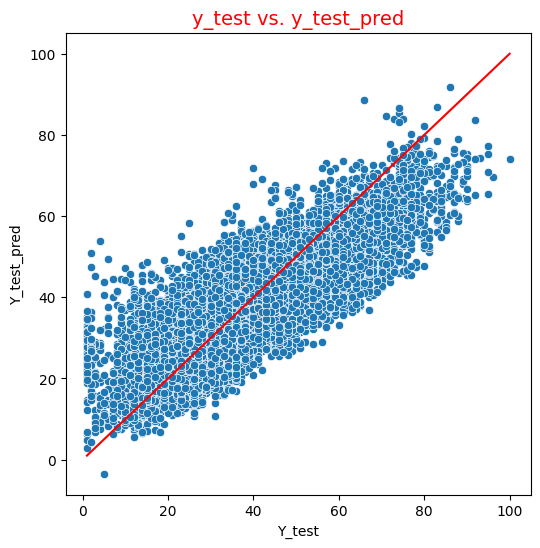

In [52]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_test, y=y_test_pred)
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax)
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')
ax.set_title('y_test vs. y_test_pred', fontsize=14, color='red')
plt.show()

In [53]:
poly_rmse = np.sqrt(mse(y_test, y_test_pred))
print(f"RMSE Test = {poly_rmse:.6f}")
print('Run Time = ', elapsed_5)

RMSE Test = 9.780510
Run Time =  117.77167557400026


## ElasticNet

In [57]:
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNet
# define model
model = ElasticNet()
# define model evaluation method
#cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = [1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['l1_ratio'] = [0, 1, 0.01]
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
# perform the search
results = search.fit(X_train_preprocessed, y_train)

/Users/yco/opt/anaconda3/envs/IS3107/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.238e+06, tolerance: 1.197e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/yco/opt/anaconda3/envs/IS3107/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.040e+06, tolerance: 1.178e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one

In [60]:
# summarize
print('MSE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MSE: -138.018
Config: {'alpha': 0.001, 'l1_ratio': 0}


In [59]:
from sklearn.linear_model import ElasticNet
elastic = ElasticNet(alpha=0.001, l1_ratio=0)
elastic.fit(X_train_preprocessed, y_train)
elastic_pred = elastic.predict(X_test_preprocessed)
elastic_rmse = np.sqrt(mse(y_test, elastic_pred))
print(f"RMSE Test = {elastic_rmse:.6f}")

RMSE Test = 9.902295


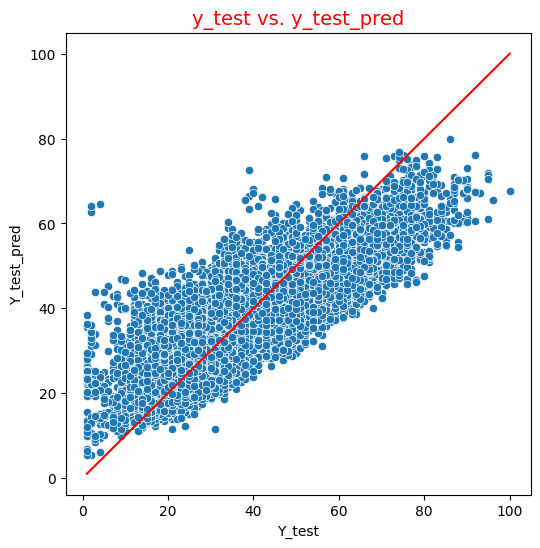

In [61]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_test, y=elastic_pred)
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax)
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')
ax.set_title('y_test vs. y_test_pred', fontsize=14, color='red')
plt.show()

## Ridge

In [63]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
 
ridge=Ridge()
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,60,65,70,75,80,85,100]}
ridge_regressor=GridSearchCV(ridge,parameters,scoring='neg_mean_squared_error',cv=5)
ridge_regressor.fit(X_train_preprocessed, y_train)

print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

{'alpha': 75}
-137.80965497540558


In [64]:
ridge = Ridge(alpha=75)
ridge.fit(X_train_preprocessed, y_train)
ridge_pred = ridge.predict(X_test_preprocessed)
ridge_rmse = np.sqrt(mse(y_test, ridge_pred))
print(f"RMSE Test = {ridge_rmse:.6f}")

RMSE Test = 9.920621


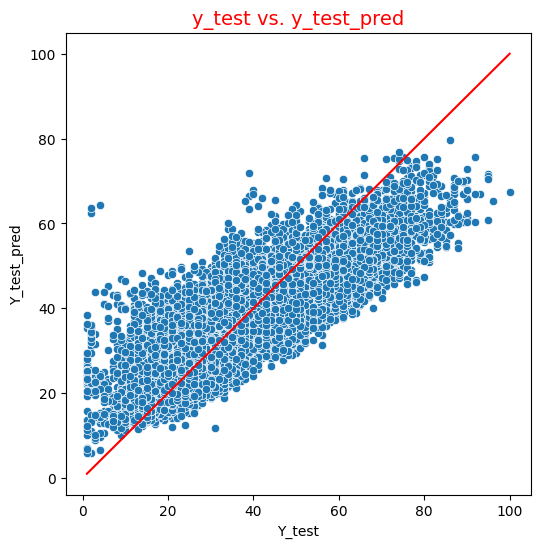

In [65]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_test, y=ridge_pred)
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax)
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')
ax.set_title('y_test vs. y_test_pred', fontsize=14, color='red')
plt.show()

## Model Comparison

Comparing Linear, Lasso, Polinomial, XGboost, KNN, the RMSE of XGboost is the highest. We may use XGboost regression for the final model.

In [73]:
rmse = [LR_rmse2,lasso_rmse,xgboost_rmse,lgbm_raw_rmse, knn_rmse,poly_rmse,elastic_rmse,ridge_rmse]
# time = [elapsed_1, elapsed_2,elapsed_3,elapsed_4,elapsed_5]
# time_predict = [elapsed_1_predict, elapsed_2_predict,elapsed_3_predict,elapsed_4_predict,elapsed_5_predict]
name = ['Linear Regression','Lasso Regression','XGboost Regression','LightGBM Regression',
        'K-Nearest-Neighbors Regression','Polynomial Regresson','ElasticNet','Ridge Regression']
r2_df = pd.DataFrame([name,rmse]).T
r2_df.columns = ['Method','RMSE Score']
r2_df

,Method,RMSE Score
0,Linear Regression,15.419653
1,Lasso Regression,9.811129
2,XGboost Regression,9.077555
3,LightGBM Regression,8.994655
4,K-Nearest-Neighbors Regression,11.547321
5,Polynomial Regresson,9.78051
6,ElasticNet,9.902295
7,Ridge Regression,9.920621


In [74]:
# export model
joblib.dump(lgbm_raw, 'Popularity Prediction Model.sav')

['Popularity Prediction Model.sav']